# Linear Regression Model

## Imports

In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RANSACRegressor
from sklearn import metrics as mt
from sklearn import model_selection as ms
from sklearn.pipeline import Pipeline

## Dataset

In [24]:
# Dados Treinamento
X_train = pd.read_csv("/home/ds_deivisson/repos/datasets/X_training_regressao.csv")
y_train = pd.read_csv("/home/ds_deivisson/repos/datasets/y_training_regressao.csv").squeeze()

# Dados Validacao
X_val = pd.read_csv("/home/ds_deivisson/repos/datasets/X_validation_regressao.csv")
y_val = pd.read_csv("/home/ds_deivisson/repos/datasets/y_validation_regressao.csv").squeeze()

# Dados Teste
X_test = pd.read_csv("/home/ds_deivisson/repos/datasets/X_test_regressao.csv")
y_test = pd.read_csv("/home/ds_deivisson/repos/datasets/y_test_regressao.csv").squeeze()

## Análise Exploratoria - Correlação e VIF

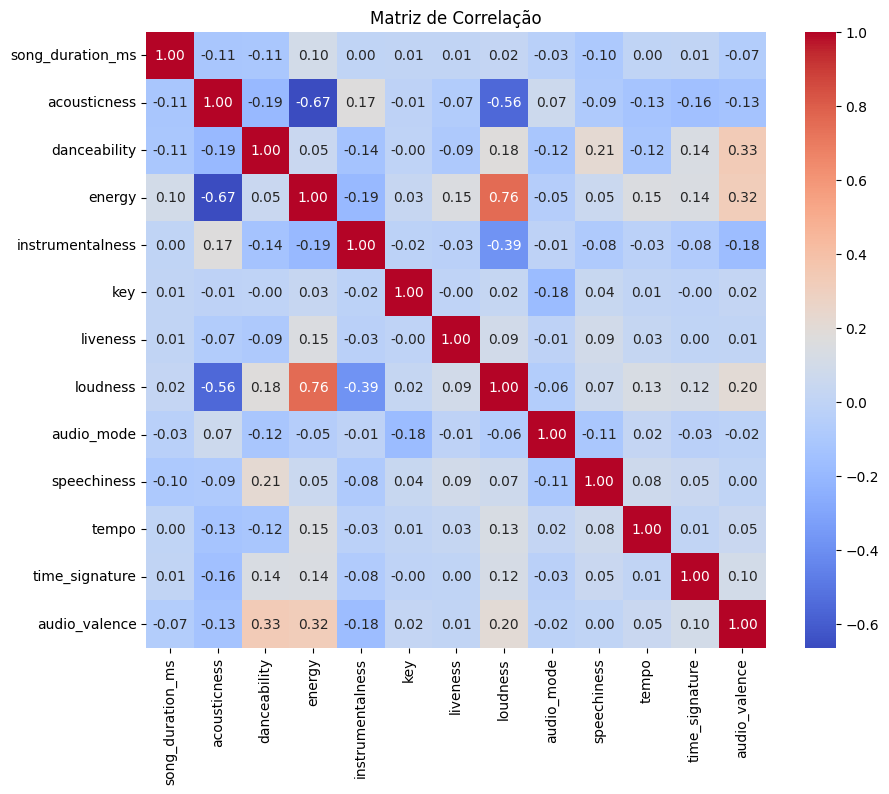

In [25]:
# Matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [26]:
# VIF - Variance Inflation Factor
X = X_train.copy()
X['intercept'] = 1

# Calculando o VIF para cada coluna
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Removendo a linha do intercepto para visualizar os resultados
print(vif_data[vif_data['feature'] != 'intercept'].sort_values(by="VIF", ascending=False))

             feature       VIF
3             energy  3.780932
7           loudness  2.978779
1       acousticness  1.994579
2       danceability  1.430540
12     audio_valence  1.395567
4   instrumentalness  1.256420
9        speechiness  1.109211
8         audio_mode  1.066040
10             tempo  1.064131
0   song_duration_ms  1.054194
6           liveness  1.049472
11    time_signature  1.044894
5                key  1.038019


## Função padrão de métricas

In [27]:
def regression_metrics(y_true, y_pred, prefix=""):
    return {
        f"R2{prefix}": mt.r2_score(y_true, y_pred),
        f"MSE{prefix}": mt.mean_squared_error(y_true, y_pred),
        f"RMSE{prefix}": np.sqrt(mt.mean_squared_error(y_true, y_pred)),
        f"MAE{prefix}": mt.mean_absolute_error(y_true, y_pred),
        f"MAPE{prefix}": mt.mean_absolute_percentage_error(y_true, y_pred),
    }

## Pipeline do Modelo

In [28]:
pipelines = {
    "linear": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(max_iter=5000))
    ]),

    "ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge())
    ]),

    "elastic": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(max_iter=5000))
    ]),

    "ransac": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RANSACRegressor())
    ])
}

## Grid de hiperparâmetros (fine tuning)

In [29]:
param_grids = {
    "linear": {},

    "lasso": {
        "model__alpha": [0.01, 0.1, 1.0]
    },

    "ridge": {
        "model__alpha": [0.1, 1.0, 10.0, 50.0]
    },

    "elastic": {
        "model__alpha": [0.01, 0.1, 1.0],
        "model__l1_ratio": [0.2, 0.5, 0.8]
    },

    "ransac": {
        "model__estimator": [
            LinearRegression(),
            Ridge(alpha=1.0),
            Ridge(alpha=10.0),
            Lasso(alpha=0.01, max_iter=5000)
    ],
        "model__min_samples": [0.5, 0.7, 0.9],
        "model__residual_threshold": [1.0, 5.0, 10.0],
        "model__max_trials": [100, 300, 500]
    }
}

## Tuning com validação (GridSearch)

In [30]:
best_models = {}

for name, pipe in pipelines.items():
    print(f"\nTuning model: {name}")

    gs = ms.GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    )

    gs.fit(X_train, y_train)

    best_models[name] = gs.best_estimator_

    print("Best params:", gs.best_params_)


Tuning model: linear
Best params: {}

Tuning model: lasso
Best params: {'model__alpha': 0.01}

Tuning model: ridge
Best params: {'model__alpha': 50.0}

Tuning model: elastic
Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.2}

Tuning model: ransac
Best params: {'model__estimator': LinearRegression(), 'model__max_trials': 300, 'model__min_samples': 0.9, 'model__residual_threshold': 1.0}


## Avaliação — Treino e Validação

In [31]:
results = {}

for name, model in best_models.items():
    print(f"\nModel: {name}")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics_train = regression_metrics(y_train, y_train_pred, "_train")
    metrics_val = regression_metrics(y_val, y_val_pred, "_val")

    results[name] = {**metrics_train, **metrics_val}

    for k, v in results[name].items():
        print(f"{k}: {v:.4f}")


Model: linear
R2_train: 0.0461
MSE_train: 455.9961
RMSE_train: 21.3541
MAE_train: 16.9982
MAPE_train: 8.6532
R2_val: 0.0399
MSE_val: 458.4470
RMSE_val: 21.4114
MAE_val: 17.0398
MAPE_val: 8.6825

Model: lasso
R2_train: 0.0461
MSE_train: 455.9980
RMSE_train: 21.3541
MAE_train: 16.9987
MAPE_train: 8.6545
R2_val: 0.0400
MSE_val: 458.4289
RMSE_val: 21.4110
MAE_val: 17.0392
MAPE_val: 8.6832

Model: ridge
R2_train: 0.0461
MSE_train: 455.9973
RMSE_train: 21.3541
MAE_train: 16.9986
MAPE_train: 8.6534
R2_val: 0.0399
MSE_val: 458.4355
RMSE_val: 21.4111
MAE_val: 17.0395
MAPE_val: 8.6819

Model: elastic
R2_train: 0.0460
MSE_train: 456.0003
RMSE_train: 21.3542
MAE_train: 16.9990
MAPE_train: 8.6539
R2_val: 0.0400
MSE_val: 458.4257
RMSE_val: 21.4109
MAE_val: 17.0393
MAPE_val: 8.6816

Model: ransac
R2_train: 0.0459
MSE_train: 456.0945
RMSE_train: 21.3564
MAE_train: 16.9833
MAPE_train: 8.6631
R2_val: 0.0393
MSE_val: 458.7495
RMSE_val: 21.4184
MAE_val: 17.0335
MAPE_val: 8.6994


## Treinamento final (Train + Val)

In [32]:
X_final = pd.concat([X_train, X_val])
y_final = np.concatenate([y_train, y_val])

In [33]:
final_models = {}

for name, model in best_models.items():
    model.fit(X_final, y_final)
    final_models[name] = model

## Avaliação final — Dados Teste

In [34]:
test_results = {}

for name, model in final_models.items():
    print(f"\nFinal Test - Model: {name}")

    y_test_pred = model.predict(X_test)
    metrics_test = regression_metrics(y_test, y_test_pred, "_test")

    test_results[name] = metrics_test

    for k, v in metrics_test.items():
        print(f"{k}: {v:.4f}")


Final Test - Model: linear
R2_test: 0.0512
MSE_test: 461.9884
RMSE_test: 21.4939
MAE_test: 17.1442
MAPE_test: 8.5314

Final Test - Model: lasso
R2_test: 0.0511
MSE_test: 462.0401
RMSE_test: 21.4951
MAE_test: 17.1449
MAPE_test: 8.5337

Final Test - Model: ridge
R2_test: 0.0511
MSE_test: 462.0259
RMSE_test: 21.4948
MAE_test: 17.1448
MAPE_test: 8.5322

Final Test - Model: elastic
R2_test: 0.0510
MSE_test: 462.0892
RMSE_test: 21.4963
MAE_test: 17.1458
MAPE_test: 8.5337

Final Test - Model: ransac
R2_test: 0.0504
MSE_test: 462.3614
RMSE_test: 21.5026
MAE_test: 17.1324
MAPE_test: 8.5580


## Interpretação de coeficientes (pós-scaling)

In [35]:
def extract_coefficients(model, feature_names):
    scaler = model.named_steps["scaler"]
    reg = model.named_steps["model"]

    coef = reg.coef_ / scaler.scale_

    return pd.DataFrame({
        "feature": feature_names,
        "coef": coef
    }).sort_values(by="coef", key=np.abs, ascending=False)

In [37]:
# Exemplo ridge
coef_ridge = extract_coefficients(final_models["ridge"], X_train.columns)
print(coef_ridge)

             feature       coef
2       danceability  13.640089
3             energy  -9.900595
4   instrumentalness  -9.603030
11    time_signature   8.918200
12     audio_valence  -8.855597
6           liveness  -4.211375
1       acousticness  -2.833734
7           loudness   2.599672
9        speechiness  -1.311296
5                key  -1.068912
10             tempo  -0.329519
0   song_duration_ms  -0.310068
8         audio_mode  -0.082275


## Análise de resíduos (modelo escolhido)

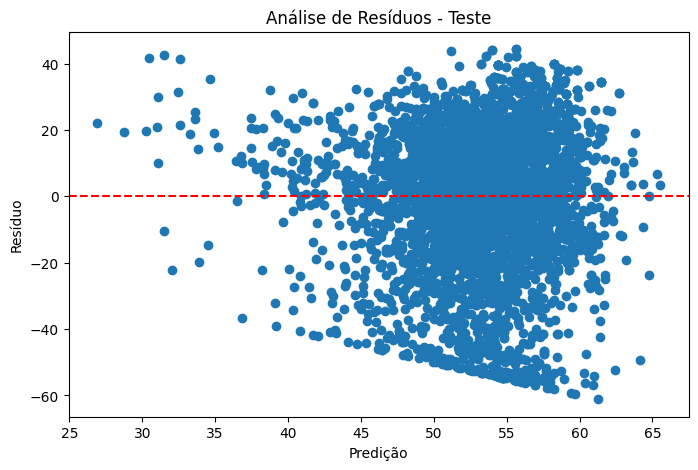

In [38]:
chosen_model = final_models["ridge"]

residuals = y_test - chosen_model.predict(X_test)

plt.figure(figsize=(8, 5))
plt.scatter(chosen_model.predict(X_test), residuals)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predição")
plt.ylabel("Resíduo")
plt.title("Análise de Resíduos - Teste")
plt.show()